Found 49 images belonging to 4 classes.
Found 10 images belonging to 4 classes.
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.2012 - loss: -143.2844 - val_accuracy: 0.2000 - val_loss: -1356.5931
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.1671 - loss: -3300.8979 - val_accuracy: 0.2000 - val_loss: -13146.4434
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.1951 - loss: -23387.7656 - val_accuracy: 0.2000 - val_loss: -64875.9297
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.1334 - loss: -90818.9844 - val_accuracy: 0.2000 - val_loss: -222037.6562
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.1461 - loss: -314074.4688 - val_accuracy: 0.2000 - val_loss: -636079.0000
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.2073 - loss: -789914.8750 - val_accuracy: 0.2000 - val_loss: -1553953.2500
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.1522 - loss: -1890740.750

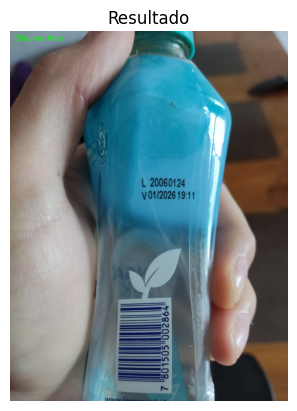

In [18]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pytesseract
import matplotlib.pyplot as plt
import re
import shutil  # Para mover archivos

# Configuración de Tesseract OCR
pytesseract.pytesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'  # Cambia esta ruta si Tesseract está en otra ubicación

# Definir el modelo CNN
def build_model():
    model = Sequential([
        Input(shape=(128, 128, 1)),  # Entrada de imagen en escala de grises de 128x128
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')  # Salida binaria (0: falsa, 1: real)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Cargar el modelo
model = build_model()

# Configurar generador de datos para cargar las imágenes de las carpetas "reales" y "falsas"
def load_data(train_dir, target_size=(128, 128), batch_size=4):
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # 20% de validación
    train_data = datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='binary',
        subset='training'
    )
    val_data = datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='binary',
        subset='validation'
    )
    return train_data, val_data

# Entrenar el modelo con los datos de las carpetas "reales" y "falsas"
def train_model(train_data, val_data, epochs=10):
    history = model.fit(train_data, validation_data=val_data, epochs=epochs)
    return history

# Función para preprocesar imagen para OCR (con umbralización)
def preprocess_for_ocr(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary

# Clasificación y OCR de la imagen con patrones variados de fechas
def analyze_single_image(image_path, output_dir="output"):
    legible_dir = os.path.join(output_dir, "legibles")
    no_legible_dir = os.path.join(output_dir, "no_legibles")
    os.makedirs(legible_dir, exist_ok=True)
    os.makedirs(no_legible_dir, exist_ok=True)

    # Preprocesar y predecir
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"No se pudo cargar la imagen en la ruta: {image_path}")
        return
    image_resized = cv2.resize(image, (128, 128))
    image_normalized = image_resized / 255.0
    prediction = model.predict(image_normalized.reshape(1, 128, 128, 1))

    # Leer imagen original para OCR y resultados visuales
    original_image = cv2.imread(image_path)
    if original_image is None:
        print(f"No se pudo cargar la imagen en la ruta: {image_path}")
        return

    # Aplicar OCR si la predicción es positiva (real)
    if prediction[0][0] > 0.5:
        processed_image = preprocess_for_ocr(original_image)
        text = pytesseract.image_to_string(processed_image)

        # Verificar varios patrones de fecha
        if re.search(r'\b\d{2}[-./]\d{2}[-./]\d{2,4}\b', text) or \
           re.search(r'\b\d{2}:\d{2}\b', text) or \
           re.search(r'\b[ADFJMNOS]\w{2} \d{2}\b', text) or \
           re.search(r'\bEXP|MFG\b', text, re.IGNORECASE):
            print(f"Etiqueta Real con fecha legible: {text}")
            cv2.putText(original_image, "Etiqueta Real", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            output_path = os.path.join(legible_dir, os.path.basename(image_path))
        else:
            print("Etiqueta Real pero sin fecha legible")
            cv2.putText(original_image, "Fecha Ilegible", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            output_path = os.path.join(no_legible_dir, os.path.basename(image_path))
    else:
        print("Etiqueta Falsa.")
        cv2.putText(original_image, "Etiqueta Falsa", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
        output_path = os.path.join(no_legible_dir, os.path.basename(image_path))

    # Mover la imagen a la carpeta correspondiente (legibles o no_legibles)
    shutil.move(image_path, output_path)
    print(f"Imagen movida a: {output_path}")

    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title("Resultado")
    plt.axis('off')
    plt.show()

# Ruta de las carpetas de entrenamiento (donde están las carpetas "reales" y "falsas")
train_dir = "./"  # Cambia esta ruta si las carpetas están en otra ubicación

# Cargar datos de entrenamiento y validación
train_data, val_data = load_data(train_dir)

# Entrenar el modelo y obtener historial
history = train_model(train_data, val_data)

# Ejemplo de uso: analiza una imagen después del entrenamiento
analyze_single_image("prueba1.JPG")  # Cambia esta ruta a la imagen que quieres analizar
